# Forest Fire Burn Area Feature Selection
Written by: Marshall Mykietyshyn

Data hosted on [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Forest+Fires).

The purpose of this notebook is to perform feature selection on the forest fire burn area dataset, testing its affect on the results. This is a popular regression dataset found on both Kaggle and the UCI Machine Learning Repository. The two data sets are identical, but the one used here was downloaded from UCI. The forest fire weather index (FWI) system features FFMC, DMC, DC and ISI are described [here](https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi). The target variable is burn area, which can be predicted by a set of feature variables listed below. The data to be used is already pre-processed by checking for missing values, outliers and converting the categorical features numerical values.

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 0 to 11
4. day - day of the week: 0 to 6
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84


In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from my_regression import whitening_transform
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate
from lazypredict.Supervised import LazyRegressor


/home/marshineer/anaconda3/envs/regression/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Outline of Methods
Features will be scored using scikit-learn's feature_selection library. This generates a feature score using either cross-correlation or mutual information. According to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression) mutual information should not be used for continuous feature variables. Therefore, only f_regression is used here. 

Following this, a regression analysis is performed to determine the effects of features on the prediction performance. For this, a model from the decision-tree family is used, as these are blind to the underlying dataset distributions, and the data is both unnormalized and contains some non-Gaussian distributed features. Ultimately, the performance of the model with each set of features is compared to get an idea of how feature selection can affect model performance.

In [3]:
data = pd.read_csv('data/Metro_Interstate_Traffic_Volume.csv')
display(data.head(n=6))


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.00,0.00,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.00,0.00,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.00,0.00,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.00,0.00,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.00,0.00,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
5,None,291.72,0.00,0.00,1,Clear,sky is clear,2012-10-02 14:00:00,5181


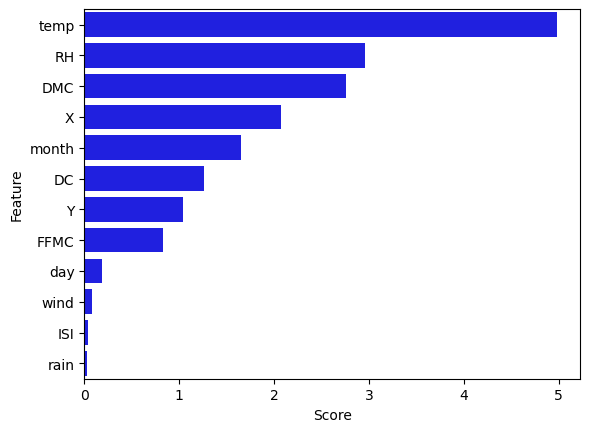

In [8]:
# Score the features using cross-correlation-based f-scoring
X = data.iloc[:, :-1]
# W = whitening_transform(X)
# X = (W @ (X - X.mean(axis=0)).T).T
y = data.iloc[:, -1]

feature_scores = SelectKBest(score_func=f_regression, k='all')
fit = feature_scores.fit(X, y)
select_feat_scores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data.columns[:-1])

select_feats = pd.concat([dfcolumns, select_feat_scores], axis=1)
select_feats.columns = ['Feature', 'Score']
# display(select_feats.sort_values(['Score'], ascending=False))

sb.barplot(x="Score", y="Feature", data=select_feats.sort_values(['Score'], ascending=False), color="b")
plt.show()


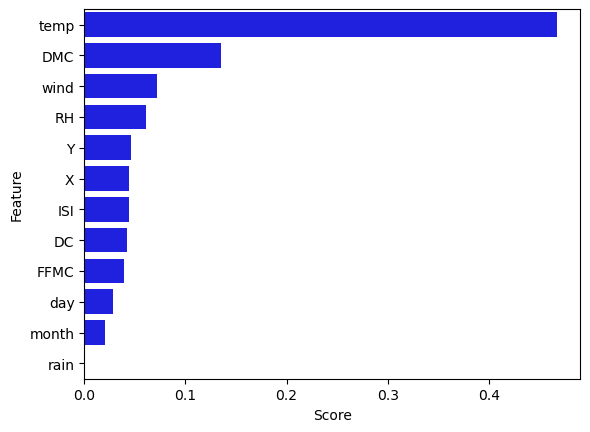

In [9]:
# Check feature importance as scored by a tree ensemble
model = RandomForestRegressor(random_state=66)
# model = ElasticNet(random_state=66)
# model = SVR()
model.fit(X, y)
tree_feats = pd.concat([dfcolumns, pd.DataFrame(model.feature_importances_)], axis=1)
tree_feats.columns = ['Feature', 'Score']
sb.barplot(x="Score", y="Feature", data=tree_feats.sort_values(['Score'], ascending=False), color="b")
plt.show()


In [5]:
# Perform a regressor analysis using consecutively fewer features
desc_feats = select_feats.sort_values(['Score'])
score_avg = np.zeros(len(desc_feats) - 1)
score_std = np.zeros_like(score_avg)
data_feats = data.copy()
for i, col in enumerate(desc_feats['Feature'][:-1]):
    data_feats.drop(columns=col, inplace=True)
    Xf, yf = data_feats.iloc[:, :-1], data_feats.iloc[:, -1]
    X_nd, y_nd = Xf.values, yf.values
    X_train, X_test, y_train, y_test = train_test_split(X_nd, y_nd, test_size=0.3, random_state=66)
    scores = cross_validate(model, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True)
    score_avg[i] = scores['test_score'].mean()
    score_std[i] = scores['test_score'].std()


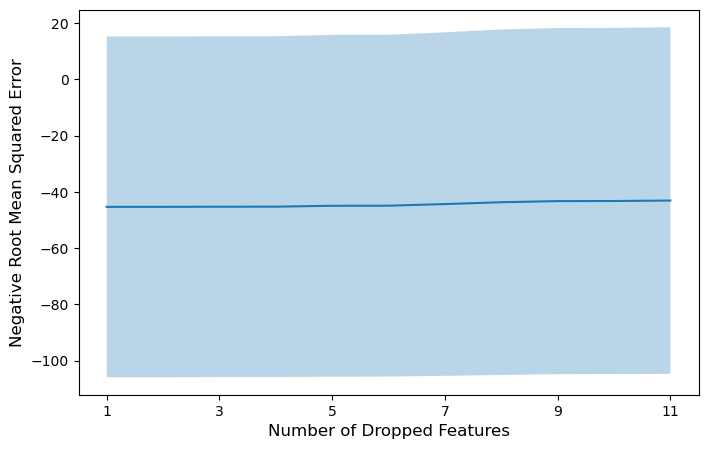

In [6]:
# Plot the cross-validation RMSE as features are dropped
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(np.arange(score_avg.size) + 1, score_avg)
ax.fill_between(np.arange(score_avg.size) + 1, score_avg - score_std, score_avg + score_std, alpha=0.3)
ax.set_xticks(np.arange(score_avg.size + 1)[1::2])
ax.set_xlabel('Number of Dropped Features', fontsize=12)
ax.set_ylabel('Negative Root Mean Squared Error', fontsize=12);
